In [81]:
!pip install Unidecode

In [0]:
import pandas as pd
import string
import nltk
import numpy as np
import sklearn
import unidecode
import seaborn as sns
import re
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from scipy.sparse import hstack
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [0]:
train_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/train.csv")
test_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/test.csv")

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [86]:
train_data.head()

,user_id,product_id,rating,label,date,review_text,day,year,word_count,punctuation_count,char_count,title_count,user_id_no_of_review,user_id_ave_rating,user_id_ave_no_words,user_id_max_review_a_day,product_id_no_of_review,product_id_ave_rating,product_id_ave_no_of_words,product_id_max_review_a_day
0,61337,1006,5.0,1,2013-10-24,"It's very rare for me to give a place 5 stars,...",Thursday,2013,244,35,1344,23,2,3.5,263.0,1,17,4.352941,161.176471,4
1,84141,1050,4.0,1,2014-08-17,Two words: Pork Belly! I would come back just...,Sunday,2014,145,22,826,14,1,4.0,145.0,1,15,3.466667,150.200000,4
2,226573,3964,4.0,1,2012-12-03,Went for a holiday meal with the family. Good ...,Monday,2012,14,4,86,2,1,4.0,14.0,1,12,3.166667,130.500000,3
3,76102,2669,3.0,1,2014-09-10,Selection was mediocre. My steak was cooked p...,Wednesday,2014,102,15,611,10,1,3.0,102.0,1,4,3.500000,237.000000,1
4,35307,914,4.0,1,2012-12-22,Had the lamb curry platter and my wife had the...,Saturday,2012,36,8,202,3,2,3.0,67.0,1,2,3.500000,44.000000,1


In [0]:
X_train=train_data.drop(['user_id','product_id','year','date','label','rating'],axis=1)
y_train=train_data.label
X_test=test_data.drop(['user_id','product_id','year','date','label'],axis=1)
y_test=test_data.label

In [0]:
pd.set_option('mode.chained_assignment', None)

### Text Preprocessing

In [0]:
#Function for expanding all the contractions in the paragraph
with open("/content/drive/My Drive/ML project'20/Contractions.json",'r') as file:
   Contractions=json.load(file)
c_re = re.compile('(%s)' % '|'.join(Contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return Contractions[match.group(0)]
    return c_re.sub(replace, text)

In [0]:
# lowercase,remove digits,punctuations,expand contractions,stopwords and lemmatization
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
X_train['review_text']=X_train['review_text'].apply(lambda x:unidecode.unidecode(x))  #Remove accented characters
X_train['review_text']=X_train['review_text'].apply(lambda x: expandContractions(x))  # expand contractions(eg. I've to I have) 
X_train['review_text']=X_train['review_text'].apply(lambda x:x.lower())   #Convert into lowercase
X_train['review_text']=X_train['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_train['review_text']=X_train['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_train['review_text']=X_train['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
X_train['review_text']=X_train['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

# Test Dataset
X_test['review_text']=X_test['review_text'].apply(lambda x: unidecode.unidecode(x))
X_test['review_text']=X_test['review_text'].apply(lambda x: expandContractions(x))
X_test['review_text']=X_test['review_text'].apply(lambda x:x.lower())   #Convert into lowercase
X_test['review_text']=X_test['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_test['review_text']=X_test['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_test['review_text']=X_test['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
X_test['review_text']=X_test['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

In [0]:
# # X_train.date=X_train.date.apply(lambda x: 10000*x.year + 100*x.month + x.day)
# col=list(X_train.drop(["review_text","day"],axis=1))
# for i in col:
#   X_train[i]=minmax_scale(X_train[i])
# # X_train.loc[0].date.year
# for i in col:
#   X_test[i]=minmax_scale(X_test[i])


## Model

### Classification on review text + features

In [92]:
# Count vectorizer for review_text
count_vect=CountVectorizer(analyzer='word')
count_vect.fit(X_train.review_text)
feature_vector_train=count_vect.transform(X_train.review_text)
feature_vector_test =count_vect.transform(X_test.review_text)
#Count Vectorizer for day
count_vect_=CountVectorizer(analyzer='word')
count_vect_.fit(X_train.day)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
# Count vectors + Features
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_no_of_review"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_ave_rating"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_ave_no_words"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_max_review_a_day"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_no_of_review"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_ave_rating"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_ave_no_of_words"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_max_review_a_day"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["word_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["punctuation_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["char_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["title_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,count_vect_.transform(X_train["day"])))

feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_no_of_review"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_ave_rating"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_ave_no_words"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_max_review_a_day"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_no_of_review"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_ave_rating"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_ave_no_of_words"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_max_review_a_day"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["word_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["punctuation_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["char_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["title_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,count_vect_.transform(X_test["day"])))

In [94]:
LR= LogisticRegression()
LR.fit(feature_vector_train,y_train)
predictions_train=LR.predict(feature_vector_train)
y_pred=LR.predict(feature_vector_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [95]:
feature_vector_test

<5025x42777 sparse matrix of type '<class 'numpy.float64'>'
	with 281019 stored elements in COOrdinate format>

In [96]:
print("Train Dataset Report:\n")
print(classification_report(y_train,predictions_train))
print("Test Dataset Report:\n")
print(classification_report(y_test,y_pred))

Train Dataset Report:

              precision    recall  f1-score   support

          -1       0.54      0.00      0.01      3353
           1       0.87      1.00      0.93     21647

    accuracy                           0.87     25000
   macro avg       0.70      0.50      0.47     25000
weighted avg       0.82      0.87      0.80     25000

Test Dataset Report:

              precision    recall  f1-score   support

          -1       0.33      0.01      0.01       474
           1       0.91      1.00      0.95      4551

    accuracy                           0.91      5025
   macro avg       0.62      0.50      0.48      5025
weighted avg       0.85      0.91      0.86      5025



In [97]:
print("Accuracy of LR on train dataset:",accuracy_score(y_train,predictions_train))
print("Accuracy of LR on test dataset :",accuracy_score(y_test,y_pred))

Accuracy of LR on train dataset: 0.86596
Accuracy of LR on test dataset : 0.9050746268656716


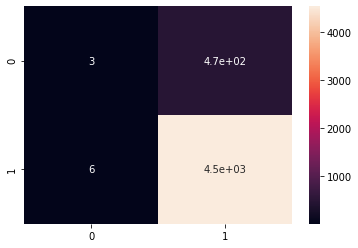

In [98]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)

### Classification on review text

In [99]:
# count_vect=CountVectorizer(analyzer='word')
# count_vect.fit(X_train.review_text)
X_train_count=count_vect.transform(X_train.review_text)
X_test_count =count_vect.transform(X_test.review_text)

LR= LogisticRegression()
LR.fit(X_train_count,y_train)
predictions_train=LR.predict(X_train_count)
predictions_test=LR.predict(X_test_count)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [100]:
print("Train Dataset Report:\n")
print(classification_report(y_train,predictions_train))
print("Test Dataset Report:\n")
print(classification_report(y_test,predictions_test))

Train Dataset Report:

              precision    recall  f1-score   support

          -1       0.98      0.50      0.66      3353
           1       0.93      1.00      0.96     21647

    accuracy                           0.93     25000
   macro avg       0.95      0.75      0.81     25000
weighted avg       0.94      0.93      0.92     25000

Test Dataset Report:

              precision    recall  f1-score   support

          -1       0.19      0.10      0.13       474
           1       0.91      0.95      0.93      4551

    accuracy                           0.87      5025
   macro avg       0.55      0.53      0.53      5025
weighted avg       0.84      0.87      0.86      5025



In [101]:
print("Accuracy of LR on train dataset:",accuracy_score(y_train,predictions_train))
print("Accuracy of LR on test dataset :",accuracy_score(y_test,predictions_test))

Accuracy of LR on train dataset: 0.93176
Accuracy of LR on test dataset : 0.8734328358208955


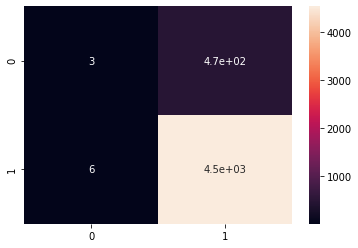

In [102]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)